In [39]:
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt
import seaborn as sns

# Define the directory where the CSV files are located
dataset_directory = './dataset'  # Update this to your actual dataset directory

# Load the data
csv_files = [f for f in os.listdir(dataset_directory) if f.endswith('.csv')]
csv_files.sort()

all_data = pd.DataFrame()

for file in csv_files:
    file_path = os.path.join(dataset_directory, file)
    temp_data = pd.read_csv(file_path)
    temp_data['TIME'] = pd.to_datetime(temp_data['TIME'])
    temp_data.columns = [col.replace(" ", "_").upper() for col in temp_data.columns]
    all_data = pd.concat([all_data, temp_data], ignore_index=True)

# Feature Engineering


/var/folders/hb/by0j9y1d48bf3nxm1bbn1bhw0000gn/T/ipykernel_97903/1626035281.py:19: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  temp_data['TIME'] = pd.to_datetime(temp_data['TIME'])
/var/folders/hb/by0j9y1d48bf3nxm1bbn1bhw0000gn/T/ipykernel_97903/1626035281.py:19: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  temp_data['TIME'] = pd.to_datetime(temp_data['TIME'])


In [2]:
import pandas as pd
import os
import matplotlib.pyplot as plt
import seaborn as sns


# Function to plot histograms
def plot_histograms(data, years, period_title, ax, max_frequency):
    for i, year in enumerate(years):
        year_data = data[data['TIME'].dt.year == year]['BIKE_USAGE']
        sns.histplot(year_data, bins=30, ax=ax[i], kde=False)
        ax[i].set_title(f'{period_title} - Year {year}')
        ax[i].set_xlabel('Bike Usage')
        ax[i].set_ylabel('Frequency')
        ax[i].set_ylim(0, max_frequency)  # Set the same y-axis limit


In [40]:
dataset_directory = './dataset/weather'  # Update this to your actual dataset directory
csv_files = [f for f in os.listdir(dataset_directory) if f.endswith('.csv')]
csv_files.sort()

weather_data = pd.DataFrame()

for file in csv_files:
    file_path = os.path.join(dataset_directory, file)
    temp_data = pd.read_csv(file_path)
    weather_data = pd.concat([weather_data, temp_data], ignore_index=True)
    weather_data['date'] = pd.to_datetime(weather_data['date'])


weather_data.head()


/var/folders/hb/by0j9y1d48bf3nxm1bbn1bhw0000gn/T/ipykernel_97903/2958745401.py:11: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  weather_data['date'] = pd.to_datetime(weather_data['date'])


,date,rain,temp,wetb,dewpt,vappr,rhum,msl
0,2018-01-08 00:00:00,0.0,14.3,12.1,10.1,12.3,75,1014.9
1,2018-01-08 01:00:00,0.0,13.8,11.8,9.9,12.2,77,1015.1
2,2018-01-08 02:00:00,0.0,12.5,10.9,9.4,11.8,81,1015.2
3,2018-01-08 03:00:00,0.0,12.0,10.4,8.8,11.3,80,1015.3
4,2018-01-08 04:00:00,0.0,13.5,11.6,9.7,12.1,77,1015.5


In [41]:
all_data = all_data.sort_values('TIME')
weather_data = weather_data.sort_values('date')

# Perform the asof merge
# This assumes that df1 is the left DataFrame and df2 is the right DataFrame
merged_df = pd.merge_asof(all_data, weather_data, left_on='TIME', right_on='date', direction='nearest')


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/seaborn/_ol

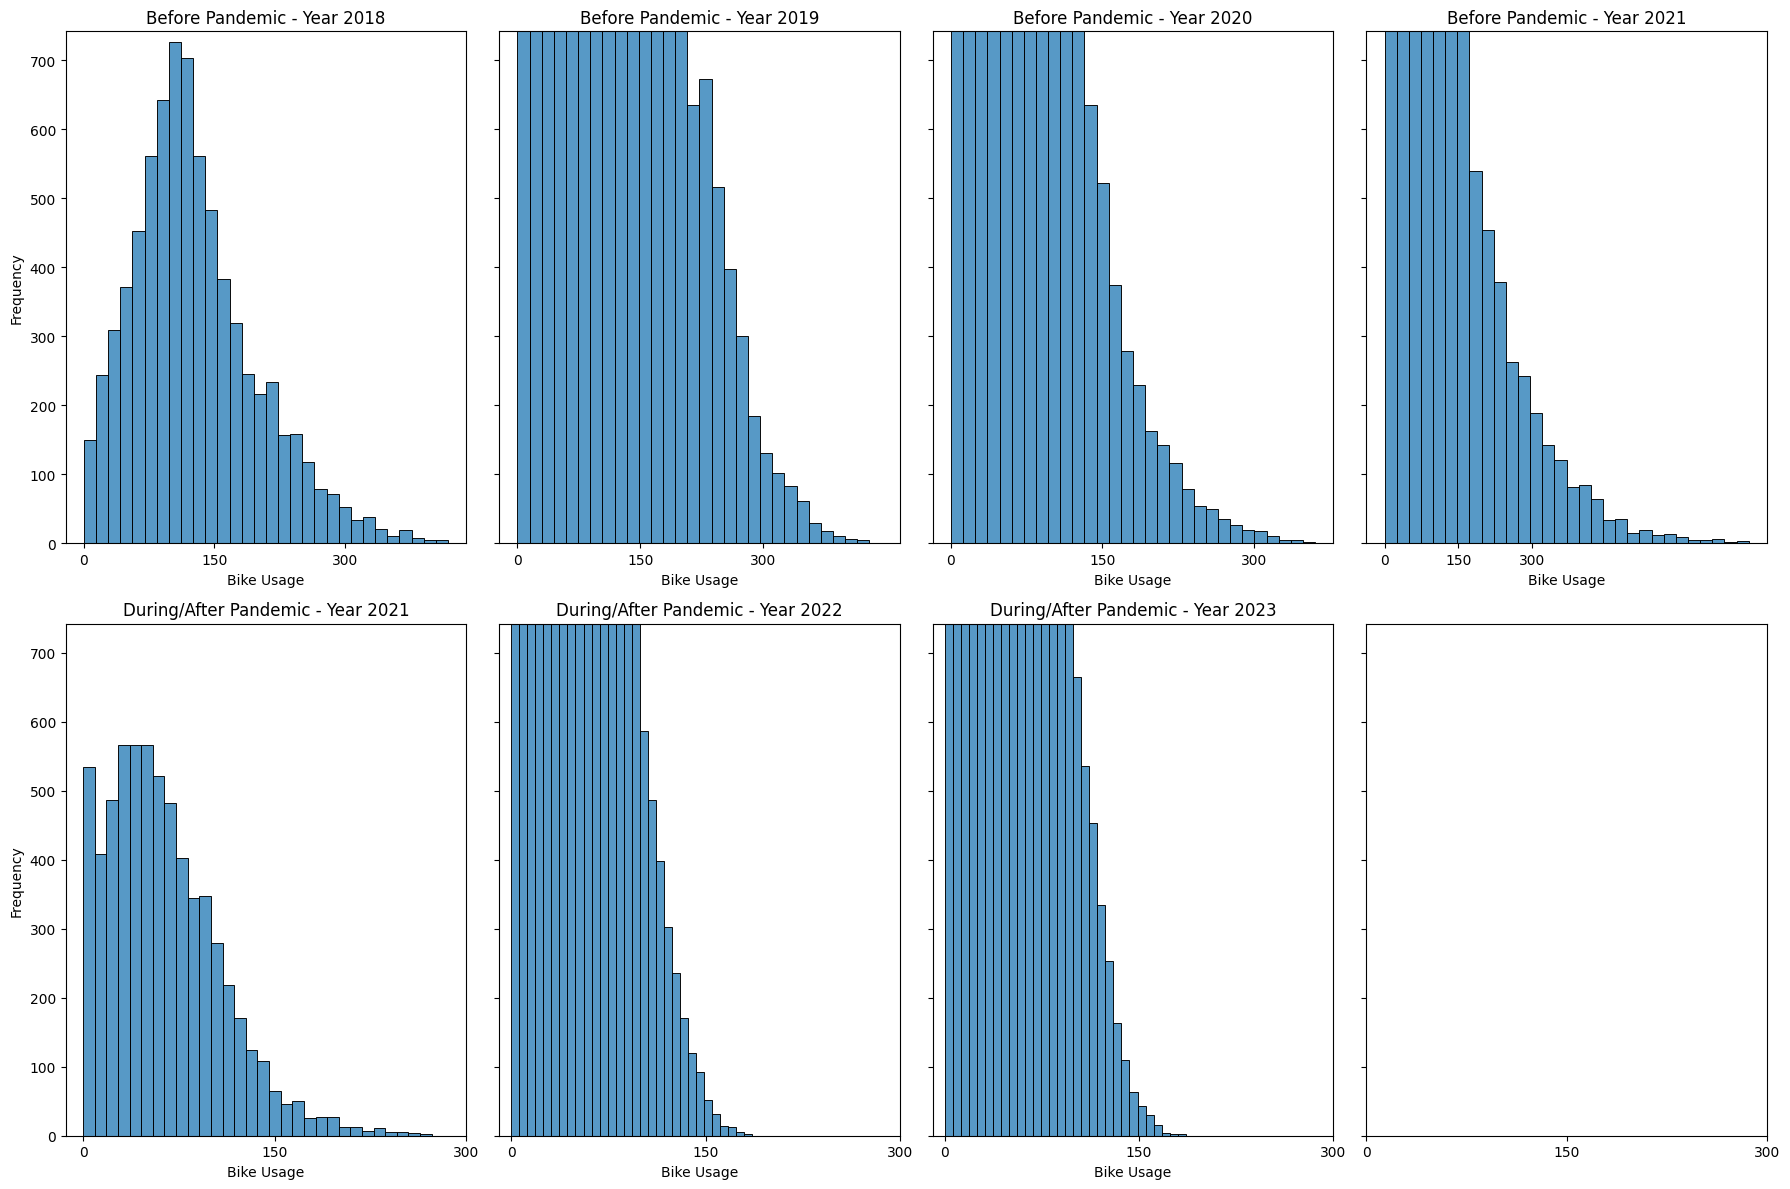

<Figure size 640x480 with 0 Axes>

In [42]:
merged_df['DAY'] = merged_df['TIME'].dt.day
merged_df['HOUR'] = merged_df['TIME'].dt.hour
merged_df['WEEKDAY'] = merged_df['TIME'].dt.weekday
merged_df['MONTH'] = merged_df['TIME'].dt.month
merged_df['YEAR'] = merged_df['TIME'].dt.year
merged_df['DAY_OF_YEAR'] = merged_df['TIME'].dt.dayofyear
merged_df['WEEK_OF_YEAR'] = merged_df['TIME'].dt.isocalendar().week
merged_df['IS_WEEKEND'] = (merged_df['WEEKDAY'] >= 5).astype(int)

# Calculate DELTA_BIKES before aggregation
merged_df['DATE'] = merged_df['TIME'].dt.date

# Calculate DELTA_BIKES before aggregation
merged_df.sort_values(by=['STATION_ID', 'TIME'], inplace=True)
merged_df['DELTA_BIKES'] = merged_df.groupby('STATION_ID')['AVAILABLE_BIKES'].diff().abs()

# Now, aggregate DELTA_BIKES to get daily BIKE_USAGE for each station
bike_usage_daily = merged_df.groupby(['STATION_ID', 'DATE'])['DELTA_BIKES'].sum().reset_index(name='BIKE_USAGE')

# Merge the aggregated data back with the merged_df to add the engineered features
bike_usage_daily = bike_usage_daily.merge(
    merged_df.drop_duplicates(subset=['STATION_ID', 'DATE']),
    left_on=['STATION_ID', 'DATE'],
    right_on=['STATION_ID', 'DATE'],
    how='left'
)

# Drop columns that are not needed after the merge
columns_to_drop = ['DATE', 'AVAILABLE_BIKES', 'DELTA_BIKES']
bike_usage_daily.drop(columns=columns_to_drop, inplace=True)

# Ensure 'TIME' is in datetime format after merging
bike_usage_daily['TIME'] = pd.to_datetime(bike_usage_daily['TIME'])


# Plotting part
# Separate the data into pre-pandemic and pandemic periods
# Before pandemic: Before March 2020
daily_before_during_pandemic = bike_usage_daily[(bike_usage_daily['YEAR'] == 2021) & (bike_usage_daily['MONTH'] <= 10) |
                                         (bike_usage_daily['YEAR'] < 2022)]
daily_after_pandemic = bike_usage_daily[(bike_usage_daily['YEAR'] >= 2022) | 
                                               (bike_usage_daily['YEAR'] == 2021) & (bike_usage_daily['MONTH'] > 10)]


# Get unique years and sort them
years_before = daily_before_during_pandemic['YEAR'].unique()
years_during_after = daily_after_pandemic['YEAR'].unique()
years_before.sort()
years_during_after.sort()

# Find the maximum bike usage frequency across all years for plotting
max_bike_usage_frequency = max(daily_before_during_pandemic['BIKE_USAGE'].max(), 
                               daily_after_pandemic['BIKE_USAGE'].max())

# Set up the matplotlib figure
num_cols = max(len(years_before), len(years_during_after))
fig, axs = plt.subplots(2, num_cols, figsize=(18, 12), sharey=True, squeeze=False)

# Define the plot_histograms function from your original code

# Plot histograms for 'Before Pandemic'
plot_histograms(daily_before_during_pandemic, years_before, 'Before Pandemic', axs[0, :], max_bike_usage_frequency)

# Plot histograms for 'During/After Pandemic'
plot_histograms(daily_after_pandemic, years_during_after, 'During/After Pandemic', axs[1, :], max_bike_usage_frequency)

# ... (your existing code for plotting histograms)

# Find the maximum bike usage frequency across all years for plotting
max_bike_usage = bike_usage_daily['BIKE_USAGE'].max()

# Define the x-axis tick intervals you want to use, e.g., every 100 units
x_ticks_interval = range(0, int(450), 150)  # Adjust the step as needed for your data

# Set the x-axis ticks for all subplots
for ax in axs.flatten():
    ax.set_xticks(x_ticks_interval)


# Show the plot
plt.tight_layout()
plt.show()

# Adjust the layout and display the plot
plt.tight_layout()
plt.show()

In [6]:
print(daily_before_during_pandemic.columns)

Index(['STATION_ID', 'BIKE_USAGE', 'TIME', 'LAST_UPDATED', 'NAME',
       'BIKE_STANDS', 'AVAILABLE_BIKE_STANDS', 'STATUS', 'ADDRESS', 'LATITUDE',
       'LONGITUDE', 'date', 'rain', 'temp', 'wetb', 'dewpt', 'vappr', 'rhum',
       'msl', 'DAY', 'HOUR', 'WEEKDAY', 'MONTH', 'YEAR', 'DAY_OF_YEAR',
       'WEEK_OF_YEAR', 'IS_WEEKEND'],
      dtype='object')


In [7]:
numerical_features = daily_before_during_pandemic.select_dtypes(include=['int64', 'float64','int32']).columns.tolist()
print(numerical_features)
# Assuming 'bike_usage_daily' is your DataFrame


['STATION_ID', 'BIKE_USAGE', 'BIKE_STANDS', 'AVAILABLE_BIKE_STANDS', 'LATITUDE', 'LONGITUDE', 'rain', 'temp', 'wetb', 'dewpt', 'vappr', 'rhum', 'msl', 'DAY', 'HOUR', 'WEEKDAY', 'MONTH', 'YEAR', 'DAY_OF_YEAR', 'IS_WEEKEND']


YEAR: 0.2092394533909166
LONGITUDE: 0.14236749235854967
DAY_OF_YEAR: 0.13975460008614016
LATITUDE: 0.1291426012852077
STATION_ID: 0.11376032333844888
MONTH: 0.04748338823808119
BIKE_STANDS: 0.041430487997719895
WEEKDAY: 0.03897041938987532
AVAILABLE_BIKE_STANDS: 0.0371330808897177
IS_WEEKEND: 0.03160028107141901
msl: 0.015168984848448142
DAY: 0.014290591992504051
rhum: 0.010046428395947762
temp: 0.007470823563210307
dewpt: 0.006230344235807867
wetb: 0.0061579500995126955
vappr: 0.005789394645184458
rain: 0.0027638041690997584
HOUR: 0.0011995500042089294


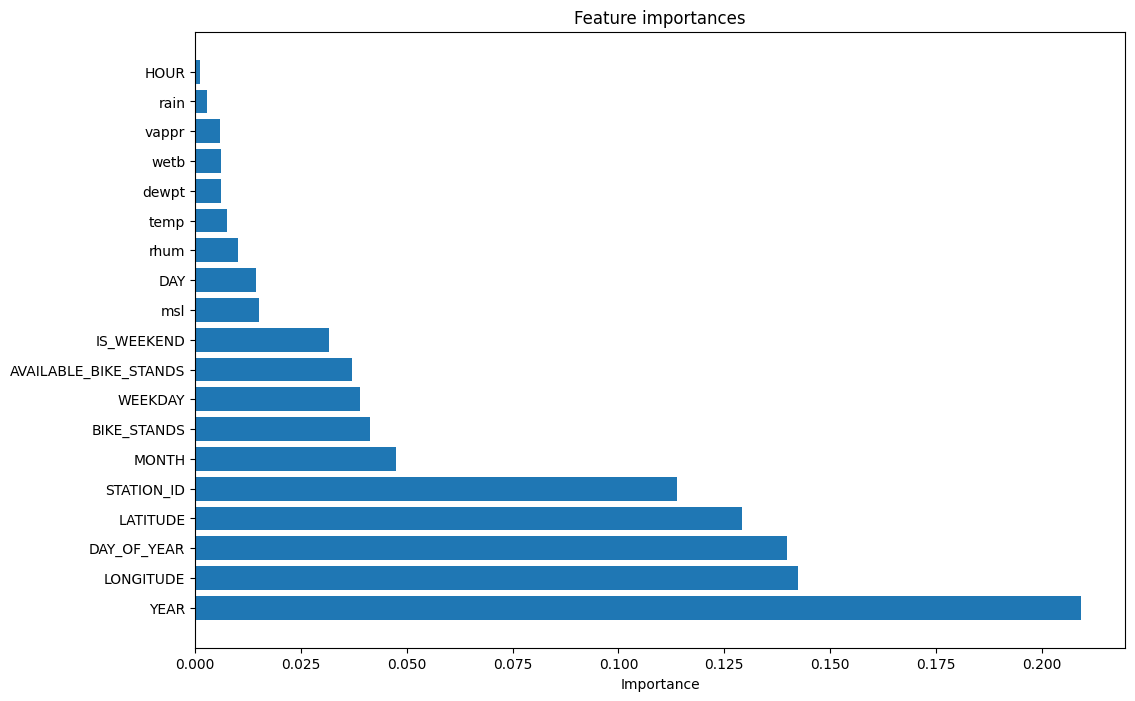

In [8]:
from sklearn.ensemble import RandomForestRegressor  # or RandomForestClassifier, depending on your task
from sklearn.model_selection import train_test_split

# Assuming bike_usage_daily is your main DataFrame and it's properly preprocessed
# Define your features (X) and target variable (y)
features_without_target = [col for col in numerical_features if col != 'BIKE_USAGE']

X = daily_before_during_pandemic[features_without_target]
# drop non-numeric or identifier columns
y = daily_before_during_pandemic['BIKE_USAGE']

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Initialize and train the model
model = RandomForestRegressor(random_state=42)  # Use RandomForestClassifier if it's a classification task
model.fit(X_train, y_train)

# Evaluate feature importances
importances = model.feature_importances_
feature_names = X.columns

# Sort the features by importance
sorted_feature_importance = sorted(zip(importances, feature_names), reverse=True)

# Print each feature with its importance
for importance, name in sorted_feature_importance:
    print(f"{name}: {importance}")

# Consider plotting for a better visual representation
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 8))
plt.title("Feature importances")
plt.barh([name for importance, name in sorted_feature_importance], [importance for importance, name in sorted_feature_importance])
plt.xlabel("Importance")
plt.show()


In [9]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
import numpy as np

# Define the features to keep
features_to_keep = ['STATION_ID', 'BIKE_STANDS', 'LATITUDE', 'LONGITUDE', 'DAY',
                     'WEEKDAY', 'MONTH', 'YEAR', 'DAY_OF_YEAR', 'IS_WEEKEND',
                       'rain', 'temp', 'wetb', 'dewpt', 'vappr', 'rhum', 'msl']


# Subset the DataFrame to include only the selected features plus the target
selected_features = bike_usage_daily[features_to_keep + ['BIKE_USAGE']]

# Convert selected features to numpy array
values = selected_features.values

# Ensure all data is float
values = values.astype('float32')

# Split the data into training and testing sets
X, y = values[:, :-1], values[:, -1]  # Separating out the features and target variable
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Normalize features with MinMaxScaler
scaler = MinMaxScaler(feature_range=(0, 1))
scaler.fit(X_train)  # Fit the scaler using only the training data

# Transform both training and testing data
X_train_scaled = scaler.transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Reshape input to be 3D [samples, timesteps, features] for LSTM
X_train_scaled = X_train_scaled.reshape((X_train_scaled.shape[0], 1, X_train_scaled.shape[1]))
X_test_scaled = X_test_scaled.reshape((X_test_scaled.shape[0], 1, X_test_scaled.shape[1]))


In [10]:
import tensorflow as tf
from keras.models import Sequential
from keras.layers import LSTM, Dropout, Dense, Bidirectional, BatchNormalization

def build_complex_model(hp):
    model = Sequential()

    # First LSTM layer with more units and return_sequences=True to stack another LSTM layer
    model.add(Bidirectional(LSTM(
        units=hp.Int('units_1', min_value=64, max_value=512, step=32),
        input_shape=(X_train_scaled.shape[1], X_train_scaled.shape[2]),
        return_sequences=True  # Allows stacking another LSTM layer
    )))
    model.add(Dropout(
        rate=hp.Float('dropout_1', min_value=0.0, max_value=0.5, step=0.1)
    ))
    
    # Batch Normalization layer after LSTM layer
    model.add(BatchNormalization())

    # Second LSTM layer with increased complexity
    model.add(Bidirectional(LSTM(
        units=hp.Int('units_2', min_value=64, max_value=512, step=32),
        return_sequences=True  # Allows stacking another LSTM layer
    )))
    model.add(Dropout(
        rate=hp.Float('dropout_2', min_value=0.0, max_value=0.5, step=0.1)
    ))
    
    # Batch Normalization layer after LSTM layer
    model.add(BatchNormalization())

    # Third LSTM layer, assuming it's the final LSTM layer
    model.add(Bidirectional(LSTM(
        units=hp.Int('units_3', min_value=64, max_value=512, step=32),
        return_sequences=False  # Last LSTM layer should not return sequences
    )))

    # Dense output layer for prediction, with ReLU activation to ensure non-negative predictions
    model.add(Dense(1, activation='relu'))

    # Compile the model
    model.compile(
    optimizer=tf.keras.optimizers.Adam(
        hp.Float('learning_rate', min_value=1e-4, max_value=1e-2, sampling='LOG')
    ),
    loss='mean_absolute_error',  # primary loss function
    metrics=['mse']  # additional metric to monitor
    )


    return model

In [11]:
# Initialize the tuner
from kerastuner.tuners import RandomSearch
from keras.callbacks import EarlyStopping

tuner = RandomSearch(
    build_complex_model,
    objective='val_loss',
    max_trials=8,  # Higher number of trials for more exhaustive search
    executions_per_trial=1,
    directory='my_dir',
    project_name='bike_usage_tuning_post_without_availablebikes_with_Weather'
)

early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

# Perform hyperparameter tuning
tuner.search(
    X_train_scaled, y_train, 
    epochs=10,  # Increased number of epochs
    validation_data=(X_test_scaled, y_test), 
    callbacks=[early_stopping],
    verbose=2
)



Trial 8 Complete [00h 16m 16s]
val_loss: 30.32169532775879

Best val_loss So Far: 15.311195373535156
Total elapsed time: 01h 32m 34s


In [12]:
# Retrieve the best model.
best_hps = tuner.get_best_hyperparameters(num_trials=1)[0]

# Build the model with the best hyperparameters.
model = build_complex_model(best_hps)

# Summary of the best model
# model.summary()

# Fit the best model
history = model.fit(
    X_train_scaled,
    y_train,
    epochs=50,  # Adjust based on when the model performance converges
    validation_data=(X_test_scaled, y_test),
    verbose=2
)


Epoch 1/50
4911/4911 - 39s - loss: 33.4648 - mse: 2747.2168 - val_loss: 28.6525 - val_mse: 2112.0178 - 39s/epoch - 8ms/step
Epoch 2/50
4911/4911 - 34s - loss: 27.5177 - mse: 1934.0186 - val_loss: 23.2154 - val_mse: 1573.9620 - 34s/epoch - 7ms/step
Epoch 3/50
4911/4911 - 35s - loss: 24.1597 - mse: 1577.0118 - val_loss: 20.2898 - val_mse: 1272.6344 - 35s/epoch - 7ms/step
Epoch 4/50
4911/4911 - 38s - loss: 22.4282 - mse: 1409.7146 - val_loss: 19.8350 - val_mse: 1246.3092 - 38s/epoch - 8ms/step
Epoch 5/50
4911/4911 - 38s - loss: 21.3093 - mse: 1302.6180 - val_loss: 17.7899 - val_mse: 986.1551 - 38s/epoch - 8ms/step
Epoch 6/50
4911/4911 - 34s - loss: 20.3322 - mse: 1204.9993 - val_loss: 17.9793 - val_mse: 1029.3457 - 34s/epoch - 7ms/step
Epoch 7/50
4911/4911 - 35s - loss: 19.5529 - mse: 1113.6465 - val_loss: 16.5797 - val_mse: 867.3711 - 35s/epoch - 7ms/step
Epoch 8/50
4911/4911 - 32s - loss: 18.9663 - mse: 1043.1183 - val_loss: 16.1351 - val_mse: 808.2073 - 32s/epoch - 7ms/step
Epoch 9/50


In [22]:
mae = model.evaluate(X_test_scaled, y_test, verbose=0)
print(f'Test MAE: {mae}')

Test MAE: [12.192934036254883, 333.60198974609375]


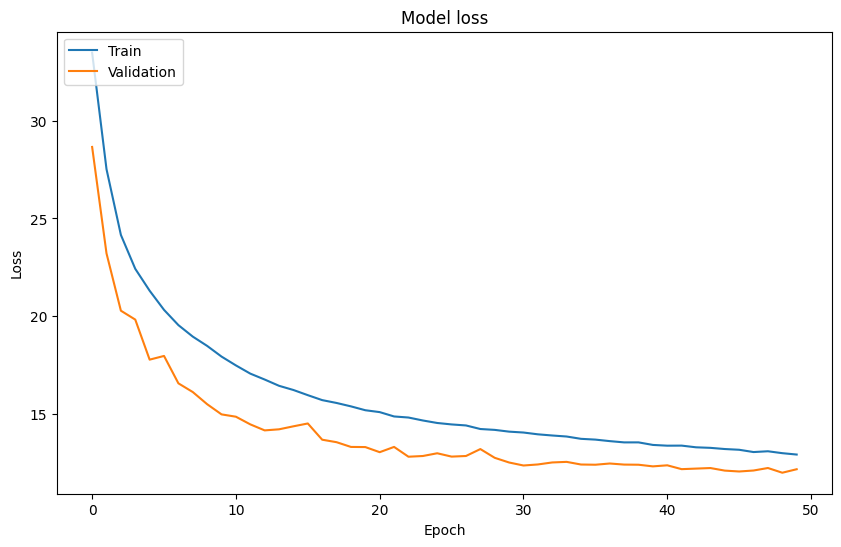

In [23]:
import matplotlib.pyplot as plt

# Plot training & validation loss values
plt.figure(figsize=(10, 6))
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()




In [24]:
# 1. Select Features
final_selected_features = daily_after_pandemic[features_to_keep]

# 2. Convert to numpy array and ensure float type
final_values = final_selected_features.values
final_values = final_values.astype('float32')
# print(final_selected_features.columns)

# 3. Normalize features with the same MinMaxScaler
final_values_scaled = scaler.transform(final_values)

# 4. Reshape input to be 3D [samples, timesteps, features] for LSTM
final_values_scaled = final_values_scaled.reshape((final_values_scaled.shape[0], 1, final_values_scaled.shape[1]))


# Make predictions

predictions = model.predict(final_values_scaled)




2770/2770 [==============================] - 5s 2ms/step


In [25]:
def plot_histograms_2(data, years, period_title, ax, max_frequency):
    for i, year in enumerate(years):
        year_data = data[data['YEAR'] == year]['BIKE_USAGE']
        sns.histplot(year_data, bins=30, ax=ax[i], kde=False)
        ax[i].set_title(f'{period_title} - Year {year}')
        ax[i].set_xlabel('Bike Usage')
        ax[i].set_ylabel('Frequency')
        ax[i].set_ylim(0, max_frequency) 

In [26]:
negatives_mask = y< 0

# Count the number of negative values
num_negatives = np.sum(negatives_mask)

print("Number of negative values: for training ", num_negatives)
print("Number of positive values: for training", len(y)- num_negatives)

negatives_mask = predictions< 0

# Count the number of negative values
num_negatives = np.sum(negatives_mask)

print("Number of negative values: for pred ", num_negatives)
print("Number of positive values for pred:", len(predictions)- num_negatives)

average_bike_usage = daily_after_pandemic['BIKE_USAGE'].mean()
print(average_bike_usage)


Number of negative values: for training  0
Number of positive values: for training 196426
Number of negative values: for pred  0
Number of positive values for pred: 88618
52.505676047755536


/var/folders/hb/by0j9y1d48bf3nxm1bbn1bhw0000gn/T/ipykernel_97903/810497961.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  final_selected_features['BIKE_USAGE'] = predictions
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context(

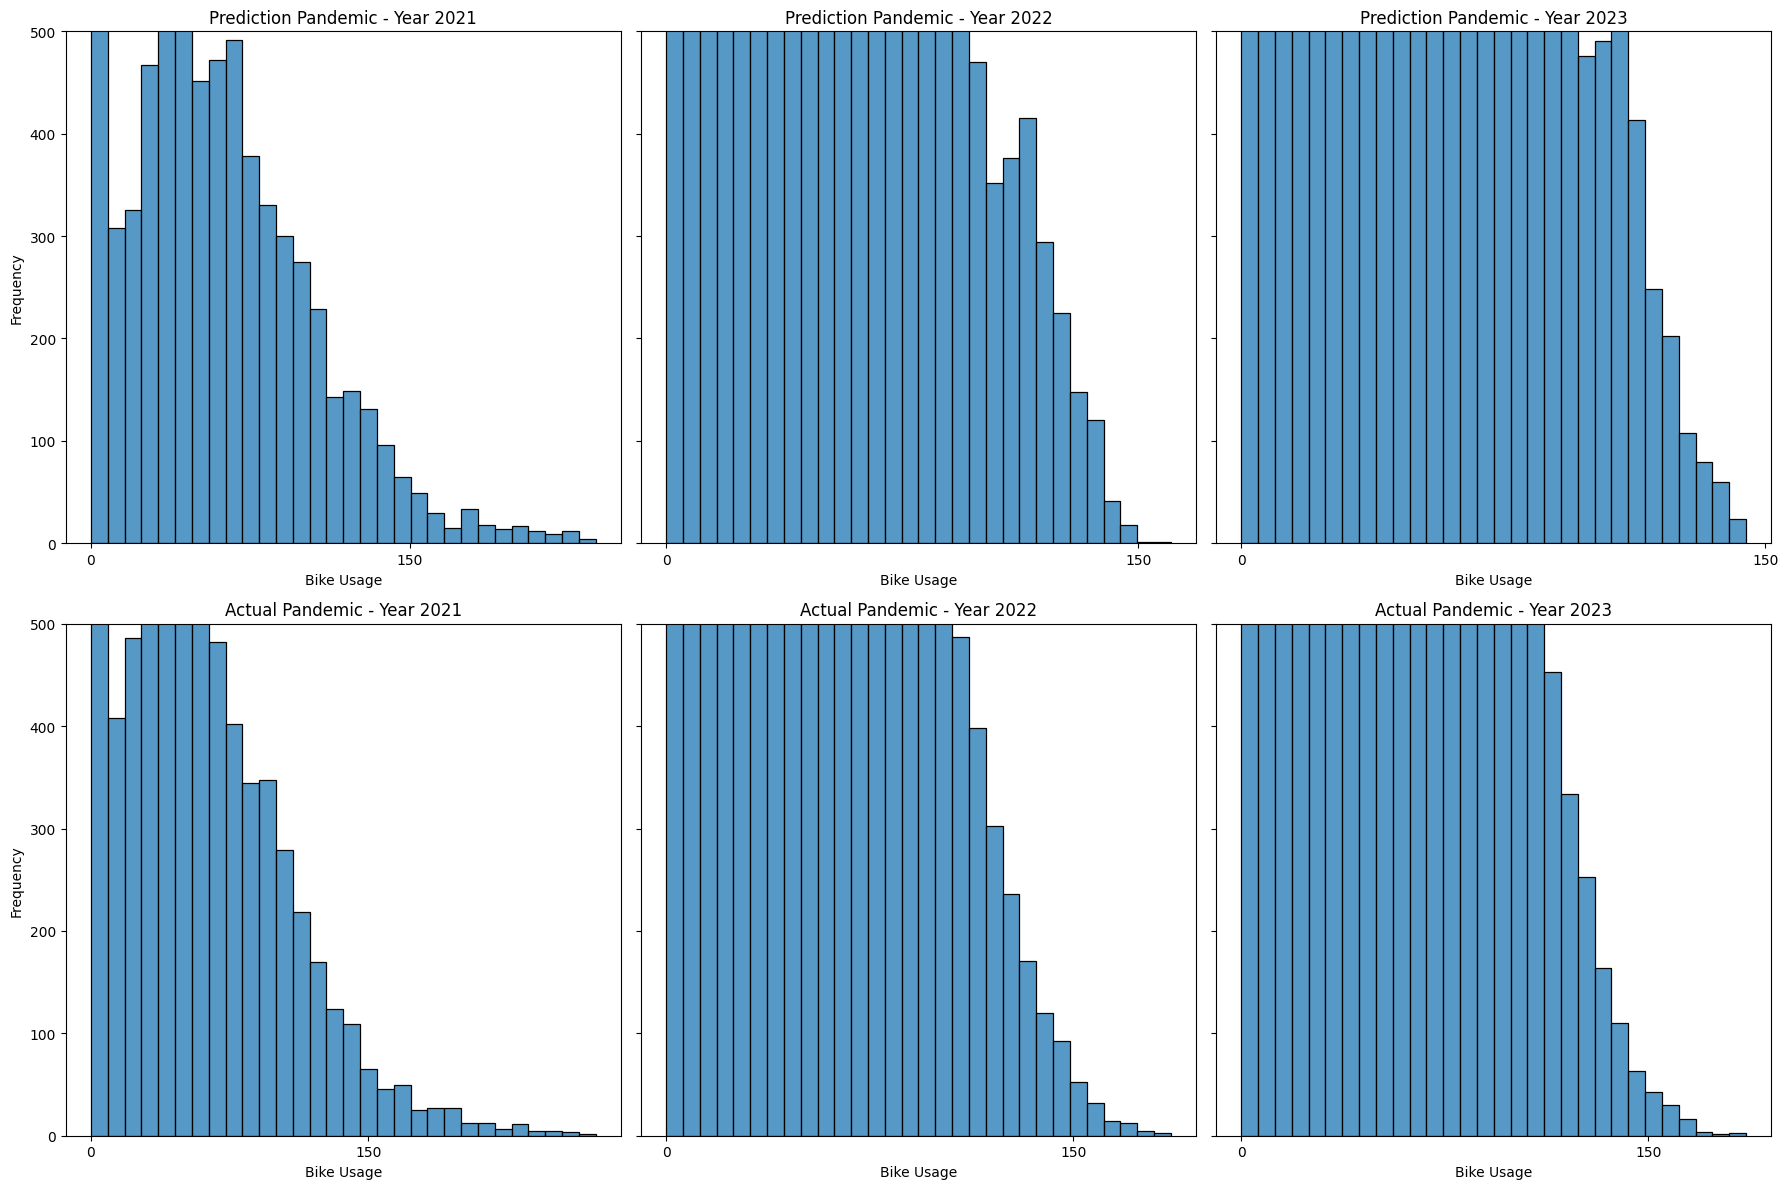

In [35]:
# Add predictions to the bike_usage_daily DataFrame
final_selected_features['BIKE_USAGE'] = predictions
max_bike_usage_frequency_2 = max(daily_after_pandemic['BIKE_USAGE'].max(), final_selected_features['BIKE_USAGE'].max())
num_cols = len(years_during_after)
fig, axs = plt.subplots(2, num_cols, figsize=(18, 12), sharey=True, squeeze=False)

# Define the plot_histograms function from your original code

# Plot histograms for 'Before Pandemic'
plot_histograms_2(final_selected_features, years_during_after, 'Prediction Pandemic', axs[0, :], 500)

# Plot histograms for 'During/After Pandemic'
plot_histograms(daily_after_pandemic, years_during_after, 'Actual Pandemic', axs[1, :], 500)

x_ticks_interval = range(0, int(300), 150)  # Adjust the step as needed for your data

# Set the x-axis ticks for all subplots
for ax in axs.flatten():
    ax.set_xticks(x_ticks_interval)
# Adjust the layout and display the plot
plt.tight_layout()
plt.show()
# final_selected_features.columns

/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/seaborn/_ol

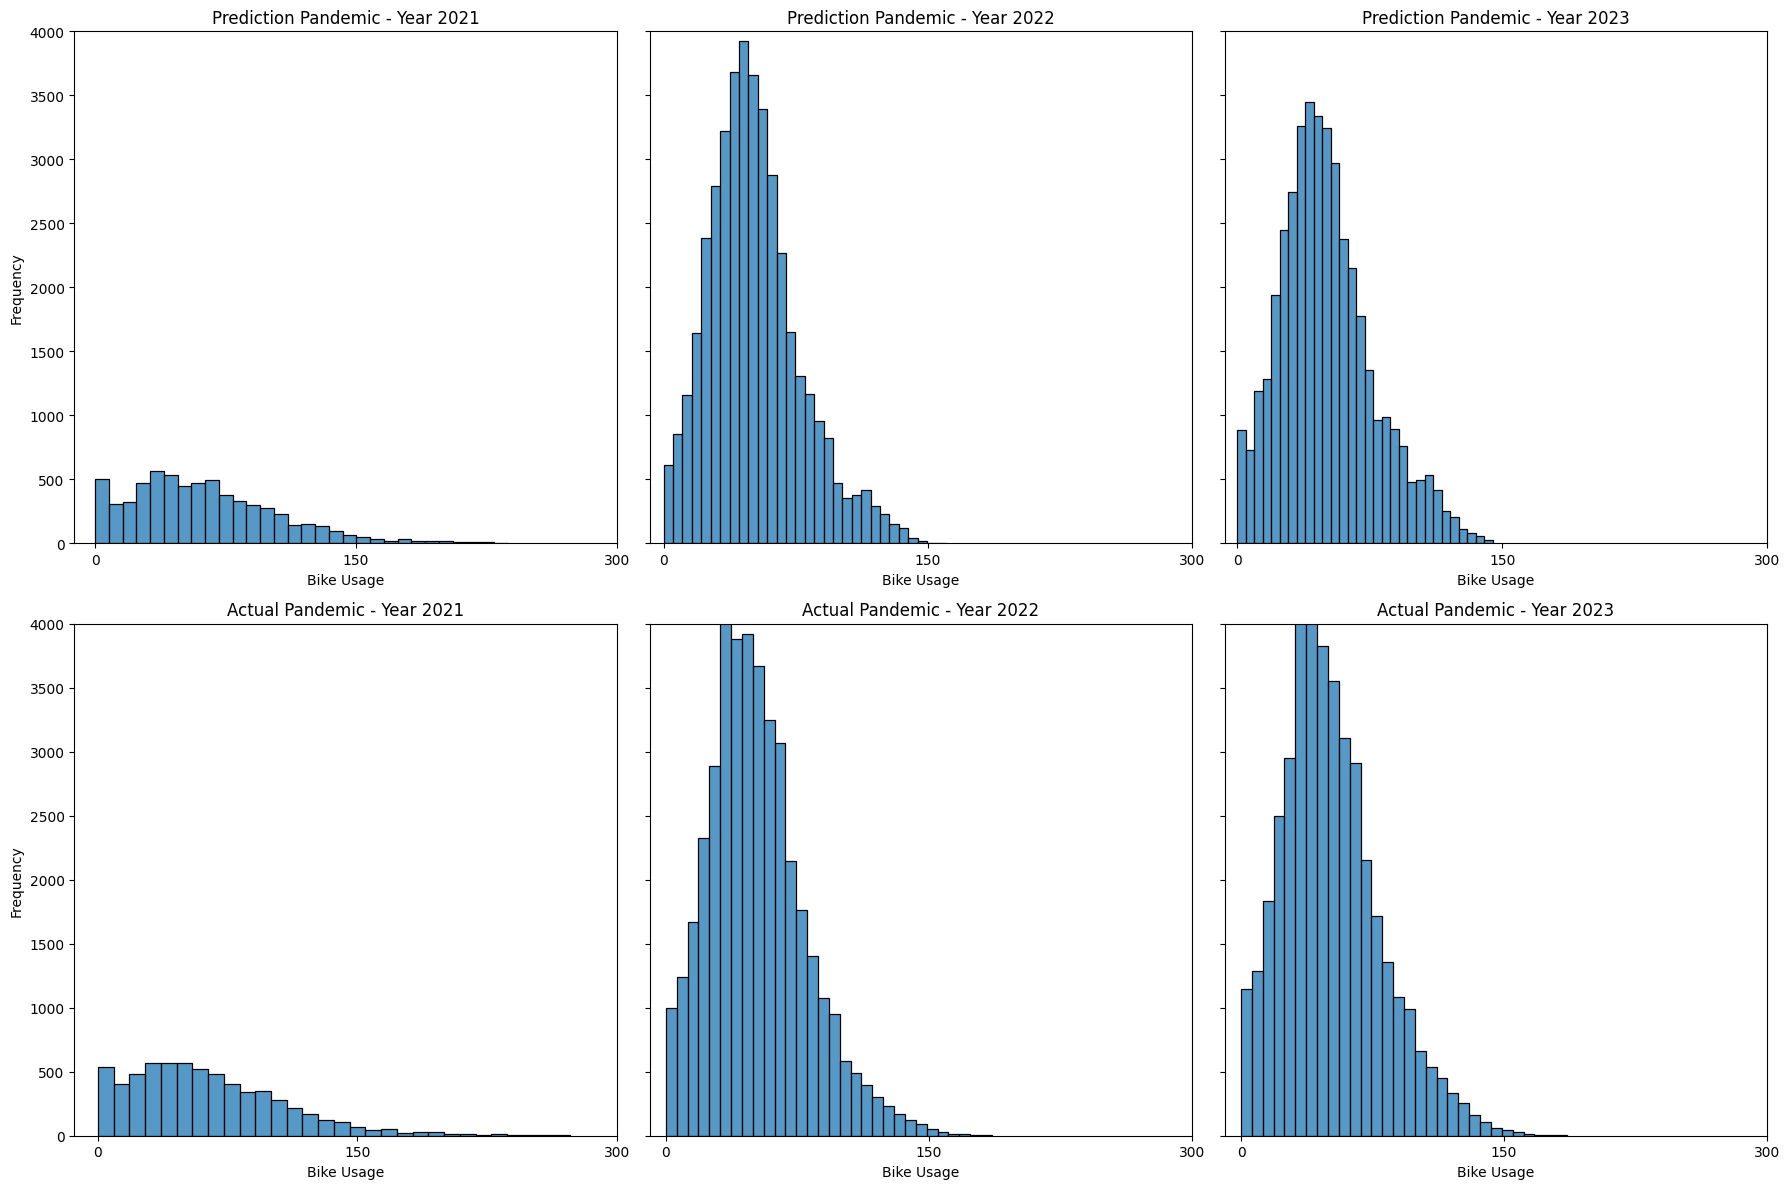

In [36]:
fig, axs = plt.subplots(2, num_cols, figsize=(18, 12), sharey=True, squeeze=False)

# Define the plot_histograms function from your original code

# Plot histograms for 'Before Pandemic'
plot_histograms_2(final_selected_features, years_during_after, 'Prediction Pandemic', axs[0, :], 4000)

# Plot histograms for 'During/After Pandemic'
plot_histograms(daily_after_pandemic, years_during_after, 'Actual Pandemic', axs[1, :], 4000)
x_ticks_interval = range(0, int(350), 150)  # Adjust the step as needed for your data

# Set the x-axis ticks for all subplots
for ax in axs.flatten():
    ax.set_xticks(x_ticks_interval)
# Adjust the layout and display the plot
plt.tight_layout()
plt.show()

In [29]:
final_selected_features['DATE'] = pd.to_datetime(final_selected_features['DAY'].astype(str) + '-' +
                                                 final_selected_features['MONTH'].astype(str) + '-' +
                                                 final_selected_features['YEAR'].astype(str), format='%d-%m-%Y')

daily_after_pandemic['DATE'] = pd.to_datetime(daily_after_pandemic['DAY'].astype(str) + '-' +
                                                     daily_after_pandemic['MONTH'].astype(str) + '-' +
                                                     daily_after_pandemic['YEAR'].astype(str), format='%d-%m-%Y')


/var/folders/hb/by0j9y1d48bf3nxm1bbn1bhw0000gn/T/ipykernel_97903/3324786714.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  final_selected_features['DATE'] = pd.to_datetime(final_selected_features['DAY'].astype(str) + '-' +
/var/folders/hb/by0j9y1d48bf3nxm1bbn1bhw0000gn/T/ipykernel_97903/3324786714.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  daily_after_pandemic['DATE'] = pd.to_datetime(daily_after_pandemic['DAY'].astype(str) + '-' +


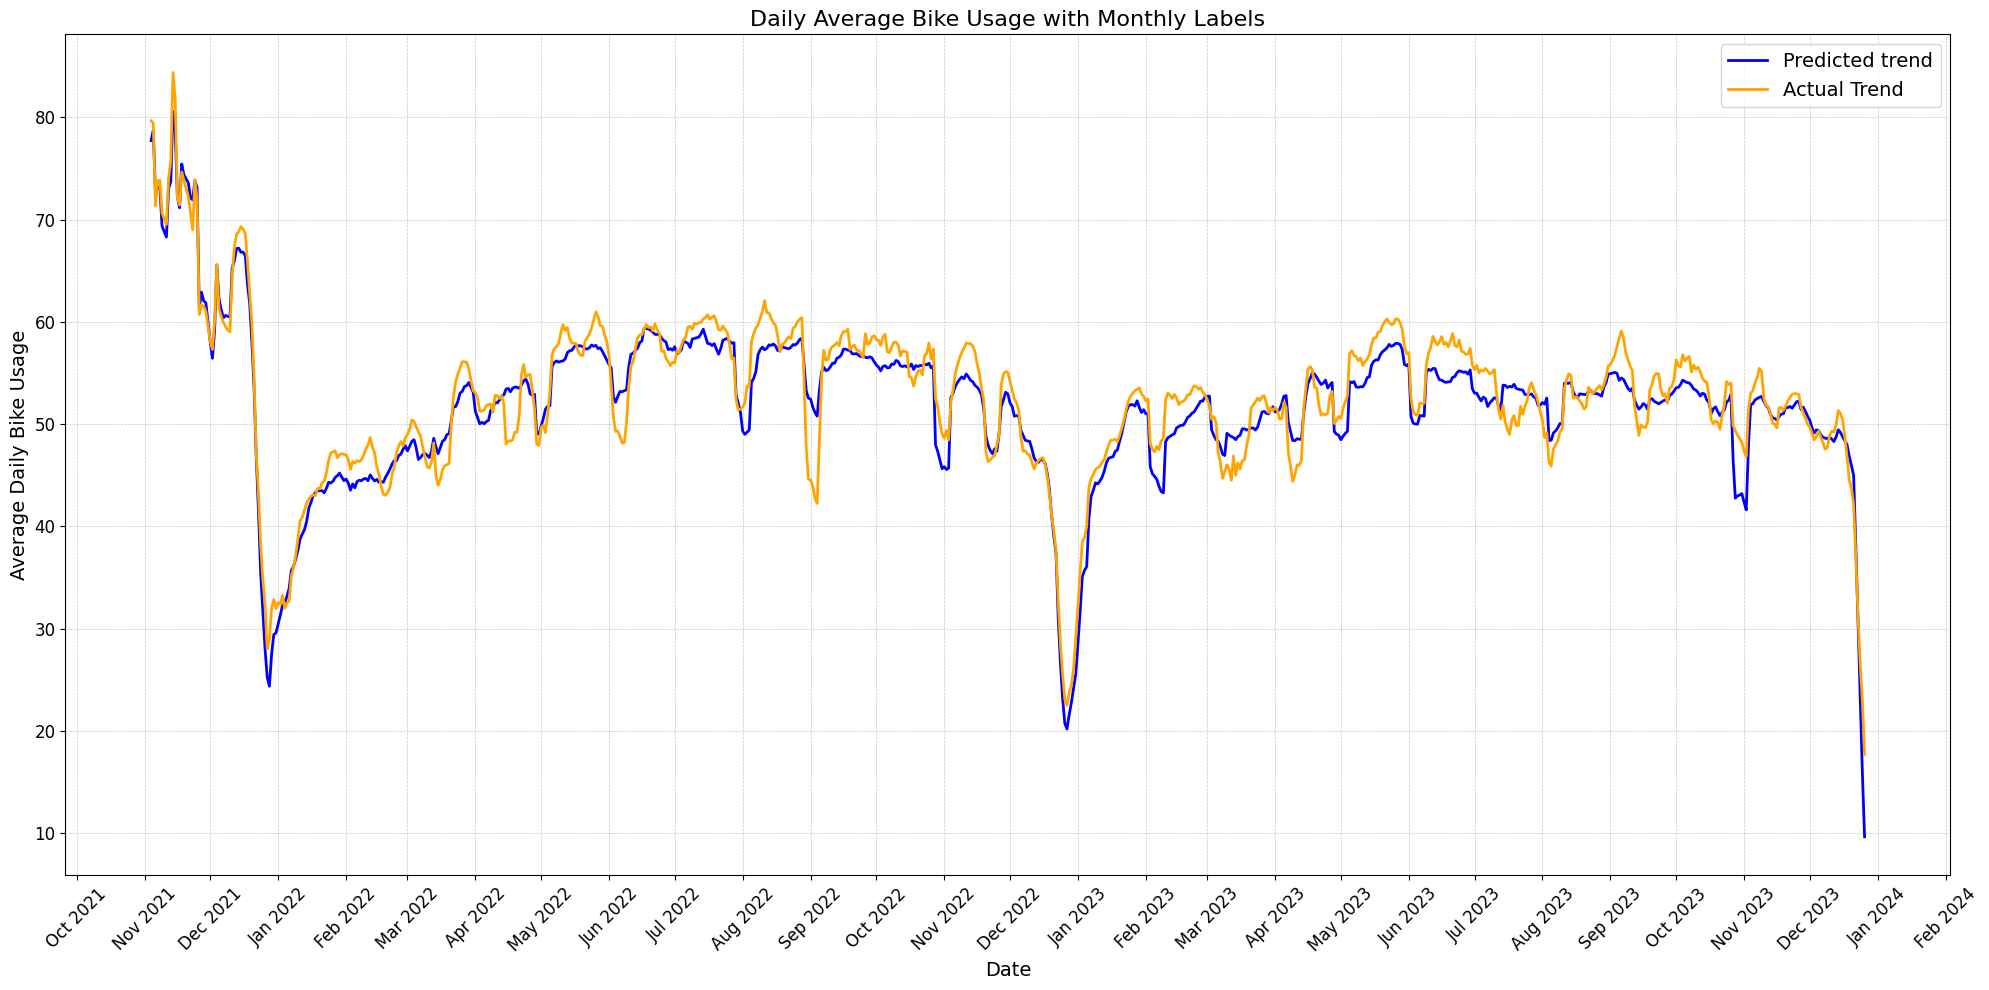

In [30]:
import matplotlib.pyplot as plt
import pandas as pd

daily_avg_final_features = final_selected_features.groupby('DATE')['BIKE_USAGE'].mean().reset_index()
daily_avg_during_after_pandemic = daily_after_pandemic.groupby('DATE')['BIKE_USAGE'].mean().reset_index()

# Assuming the data is already loaded and grouped as `daily_avg_final_features` and `daily_avg_during_after_pandemic`
# ...

# Plotting
plt.figure(figsize=(20, 10))  # Increase figure size for better readability

# Smoothing lines with rolling average; window size can be adjusted
rolling_window_size = 7  # for a weekly rolling average
daily_avg_final_features['BIKE_USAGE_SMOOTH'] = daily_avg_final_features['BIKE_USAGE'].rolling(window=rolling_window_size, center=True).mean()
daily_avg_during_after_pandemic['BIKE_USAGE_SMOOTH'] = daily_avg_during_after_pandemic['BIKE_USAGE'].rolling(window=rolling_window_size, center=True).mean()

plt.plot(daily_avg_final_features['DATE'], daily_avg_final_features['BIKE_USAGE_SMOOTH'], label='Predicted trend', color='blue', linewidth=2)
plt.plot(daily_avg_during_after_pandemic['DATE'], daily_avg_during_after_pandemic['BIKE_USAGE_SMOOTH'], label='Actual Trend', color='orange', linewidth=2)

plt.xlabel('Date', fontsize=14)
plt.ylabel('Average Daily Bike Usage', fontsize=14)
plt.title('Daily Average Bike Usage with Monthly Labels', fontsize=16)

plt.gca().xaxis.set_major_locator(plt.matplotlib.dates.MonthLocator())
plt.gca().xaxis.set_major_formatter(plt.matplotlib.dates.DateFormatter('%b %Y'))
plt.xticks(rotation=45, fontsize=12)
plt.yticks(fontsize=12)

plt.legend(fontsize=14)
plt.grid(True, which='both', linestyle='--', linewidth=0.5, alpha=0.7)
plt.tight_layout()
plt.show()
